In [1]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import random

C:\Users\Rock_\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
def load_photos(directory):
    images = []
    labels_speed = []
    labels_dir = []
    dir_list = listdir(directory)
    random.shuffle(dir_list)
    for name in dir_list:
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename, target_size=(96, 160))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        value_dir = float(name.split('_')[1])
        value_speed = float(name.split('_')[0])
        labels_dir.append(value_dir)
        labels_speed.append(value_speed)
        images.append(image)
    return images, labels_speed, labels_dir

In [25]:
dataset = "../../../../Auto_3"

In [26]:
# load images from both train and test groups
directory = dataset+'/Train'
images, labels_speed, labels_dir = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels for training: %d' % nb_images)

Loaded Images and labels for training: 704


In [27]:
#Normalise images
images = np.array(images)
images /= 255.0

In [28]:
#convert datas to dummyvalues
labels_speed = np.array(pd.get_dummies(labels_speed))
labels_dir = np.array(pd.get_dummies(labels_dir))

(array([1], dtype=uint8),
 array([0, 0, 1], dtype=uint8),
 <matplotlib.image.AxesImage at 0x166454142b0>)

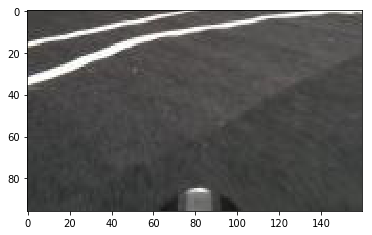

In [29]:
labels_speed[42], labels_dir[42], plt.imshow(images[42])

In [30]:
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers
import keras.callbacks

In [31]:
#from keras.models import load_model
#model = load_model("model_bigrace_original_5.h5")

In [32]:
'''
Model from PatateV2
'''

K.clear_session()
############################################################# 

img_in = Input(shape=(96, 160, 3), name='img_in')
x = img_in

x = Convolution2D(2, (5,5), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Convolution2D(4, (5,5), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.4)(x)
x = Convolution2D(8, (5,5), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.5)(x)

x = Flatten(name='flattened')(x)

x = Dense(100, use_bias=False)(x) 
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.4)(x)
x = Dense(50, use_bias=False)(x)  
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.3)(x)

# Multitask Output

out_speed = Dense(2, activation='softmax')(x)

out_dir = Dense(3, activation='softmax')(x)


# Compile Model
model = Model(inputs=[img_in], outputs=[out_speed, out_dir])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 96, 160, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 78, 2)         150       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 78, 2)         8         
_________________________________________________________________
activation_1 (Activation)    (None, 46, 78, 2)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 37, 4)         200       
_________________________________________________________________
batch_normalization_2 (Batch (None, 21, 37, 4)         16        
_________________________________________________________________
activation_2 (Activation)    (None, 21, 37, 4)         0         
__________

In [33]:
model_name="model_lille.h5"

In [34]:
#save best model if model improved
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [35]:
h = model.fit(images, [labels_dir], batch_size=64, epochs=50, validation_split=0.2, verbose=1, callbacks=[best_checkpoint])

Train on 563 samples, validate on 141 samples
Epoch 1/50
563/563 [==============================] - 10s 18ms/step - loss: 1.3404 - acc: 0.3055 - val_loss: 1.0652 - val_acc: 0.4752

Epoch 00001: val_loss improved from inf to 1.06521, saving model to model_lille_3.h5
Epoch 2/50
563/563 [==============================] - 9s 17ms/step - loss: 1.2393 - acc: 0.3979 - val_loss: 1.0248 - val_acc: 0.5035

Epoch 00002: val_loss improved from 1.06521 to 1.02477, saving model to model_lille_3.h5
Epoch 3/50
563/563 [==============================] - 10s 17ms/step - loss: 1.1611 - acc: 0.4263 - val_loss: 1.0862 - val_acc: 0.4184

Epoch 00003: val_loss did not improve
Epoch 4/50
563/563 [==============================] - 11s 19ms/step - loss: 1.0908 - acc: 0.4281 - val_loss: 0.9780 - val_acc: 0.4823

Epoch 00004: val_loss improved from 1.02477 to 0.97798, saving model to model_lille_3.h5
Epoch 5/50
563/563 [==============================] - 10s 18ms/step - loss: 0.9981 - acc: 0.5062 - val_loss: 0.914

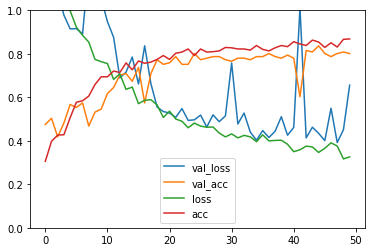

In [36]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))